In [1]:
import os
import sys
import math

sys.path.append('../../src')

import torch

from model.loss import spectral_loss

from synth.synth_constants import synth_constants


import matplotlib.pyplot as plt
%matplotlib notebook

import seaborn as sns
sns.set_style('whitegrid')

In [2]:
device = "cpu"

loss_handler = spectral_loss.SpectralLoss(loss_type="SPECTROGRAM",
                                          loss_preset="mag_logmag",
                                          synth_constants=synth_constants, device=device)

params_loss_handler = torch.nn.MSELoss()

In [3]:
def complex_oscillator_cumprod(amp, freq, sample_rate, modulator=None, waveform="sine"):
    """Implements the complex surrogate by taking the cumulative product along the time
    dimension."""
    z_freq = 2 * math.pi * freq / sample_rate

    if modulator is not None:
        z = torch.exp(1j * (z_freq + (2 * math.pi * modulator) * (100.0 / sample_rate)))
    else:
        z = torch.exp(1j * (z_freq.repeat(sample_rate)))  # complex parameter

    initial = torch.ones(*z.shape[:-1], 1, dtype=z.dtype, device=z.device)
    z_cat = torch.cat([initial, z], dim=-1)[:-1]

    signal = amp * torch.cumprod(z_cat, dim=-1).real

    if waveform == 'square':
        signal = torch.sign(signal)

    return signal

def complex_oscillator_damped(z: torch.complex, N: int):
    """Implements the complex surrogate by explicitly computing the parameters of the
    damped sinusoid equivalent."""
    n = torch.arange(N)
    return (z.abs() ** n) * torch.cos(z.angle() * n)


def real_oscillator(freq, amp, N=2048):
    """Generate real sinusoids with given frequencies, amplitudes, and phases."""
    n = torch.arange(N, dtype=torch.float32, device=freq.device)[..., None, :]
    return torch.cos(2 * math.pi * freq * n) * amp


def orig_oscillator(amp, freq, sample_rate, modulator=None, waveform='sine'):
    """Generate real sinusoids with given frequencies, amplitudes, and phases."""
    t = torch.linspace(0, 1.0, steps=sample_rate)
    if modulator is not None:
        signal = \
            amp * torch.cos(2 * math.pi * freq * t + 2 * math.pi * (torch.cumsum(modulator, dim=0) * 100.0 / sample_rate))
    else:
        signal = torch.cos(2 * math.pi * freq * t) * amp

    if waveform == 'square':
        signal = torch.sign(signal)

    return signal

In [4]:
%matplotlib notebook

carrier = real_oscillator(torch.tensor(10 / 2048), 1.0, 2048)
plt.plot(carrier[0])

<IPython.core.display.Javascript object>

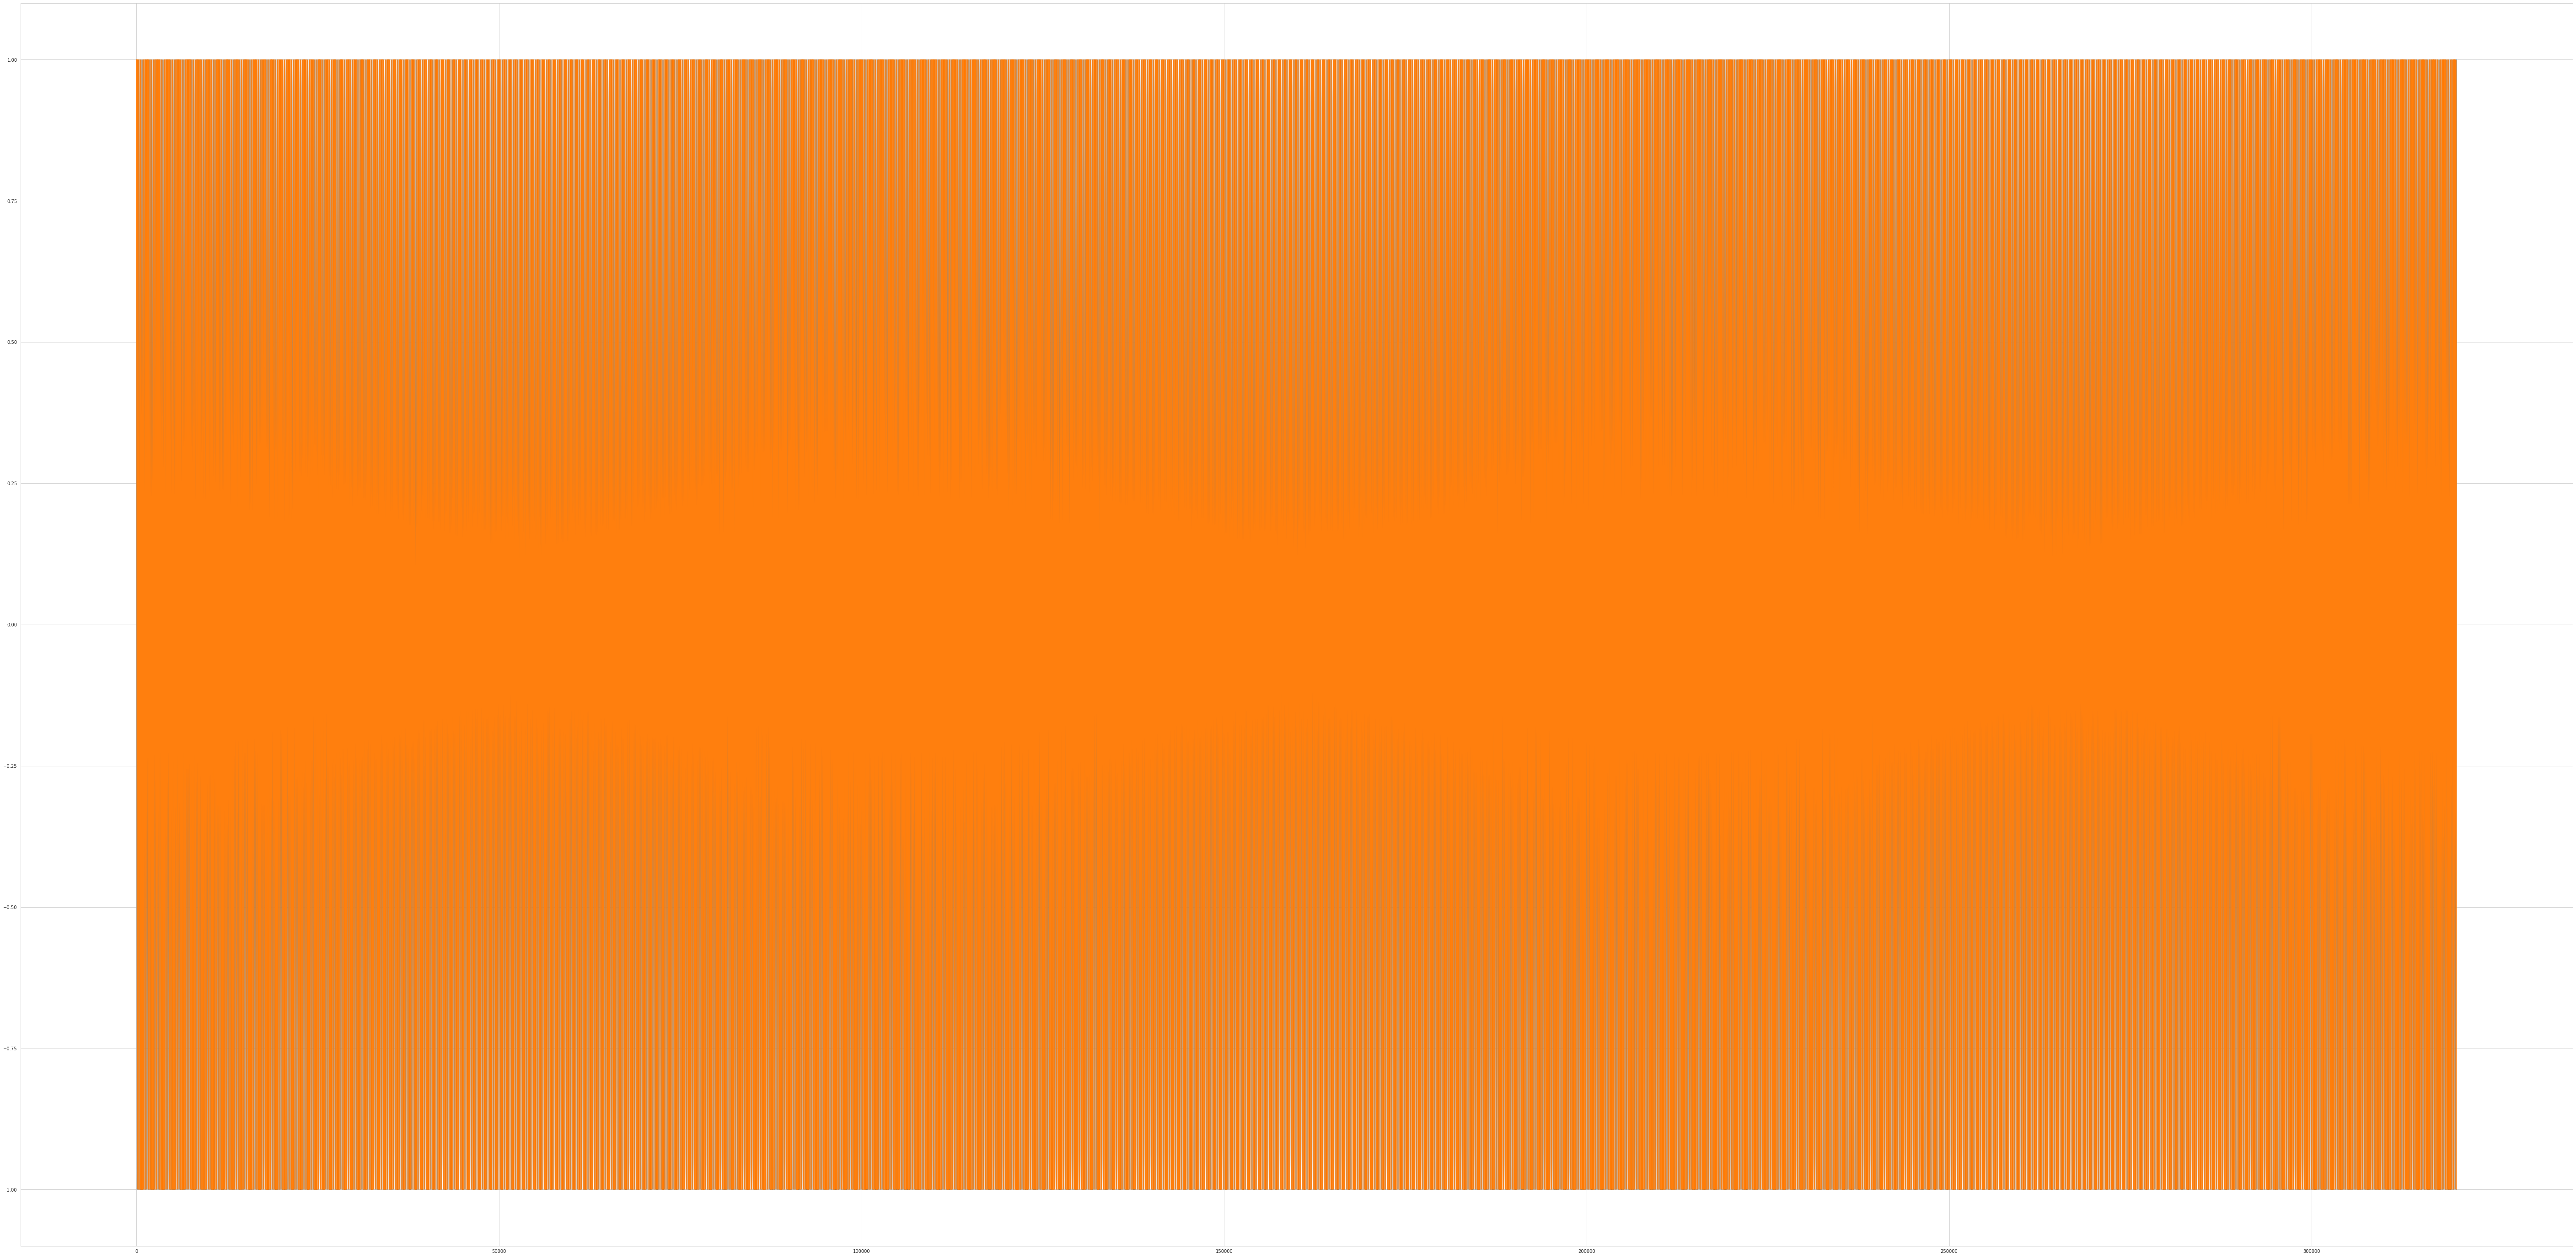

tensor(0.0125)


In [5]:
%matplotlib inline

sample_rate = 320000

amp = torch.tensor(1.0)
freq = torch.tensor(2000.0)

mod_amp = torch.tensor(1.0)
mod_freq = torch.tensor(3.0)

modulator = orig_oscillator(mod_amp, mod_freq, sample_rate)
carrier = orig_oscillator(amp, freq, sample_rate)

modulated_wave = orig_oscillator(amp, freq, sample_rate, modulator)

surrogate_carrier_wave = complex_oscillator_cumprod(amp, freq, sample_rate)
surrogate_modulated_wave = complex_oscillator_cumprod(amp, freq, sample_rate, modulator)

fig = plt.figure(figsize=(100, 50))
plt.plot(modulated_wave.cpu().detach().numpy())
plt.plot(surrogate_modulated_wave.cpu().detach().numpy())

plt.show()
print(abs(modulated_wave - surrogate_modulated_wave).mean())

In [16]:
from tqdm import tqdm
from model.model import SimpleWeightLayer

num_epochs = 4000
target_freq = torch.tensor(500.0)
target_mod_freq = torch.tensor(3.0)

target_modulator = orig_oscillator(1.0, target_mod_freq, sample_rate)
complex_target_signal = torch.unsqueeze(complex_oscillator_cumprod(1.0, target_freq, sample_rate, target_modulator), 0)
orig_target_signal = torch.unsqueeze(orig_oscillator(1.0, target_freq, sample_rate, target_modulator), 0)

frequency_layer = SimpleWeightLayer(torch.tensor(100.0))
mod_freq_layer = SimpleWeightLayer(torch.tensor(10.0))
params_container = torch.nn.ModuleList([frequency_layer, mod_freq_layer])

base_lr = 2
optimizer = torch.optim.Adam(params_container.parameters(), lr=base_lr)

train_res = []
for e in tqdm(range(num_epochs)):

    modulation_frequency_param = mod_freq_layer()
    frequency_param = frequency_layer()

    modulator = orig_oscillator(1.0, modulation_frequency_param, sample_rate)

    # predicted_signal = complex_oscillator_cumprod(1, frequency_param, sample_rate, modulator)
    predicted_signal = orig_oscillator(1, frequency_param, sample_rate, modulator)
    # loss = params_loss_handler(frequency_param, target_freq)
    loss, _, _ = loss_handler.call(orig_target_signal, torch.unsqueeze(predicted_signal, 0), step=e)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_res.append((e, modulation_frequency_param.item(), frequency_param.item(), loss.item()))

100%|███████████████████████████████████████| 4000/4000 [06:07<00:00, 10.88it/s]


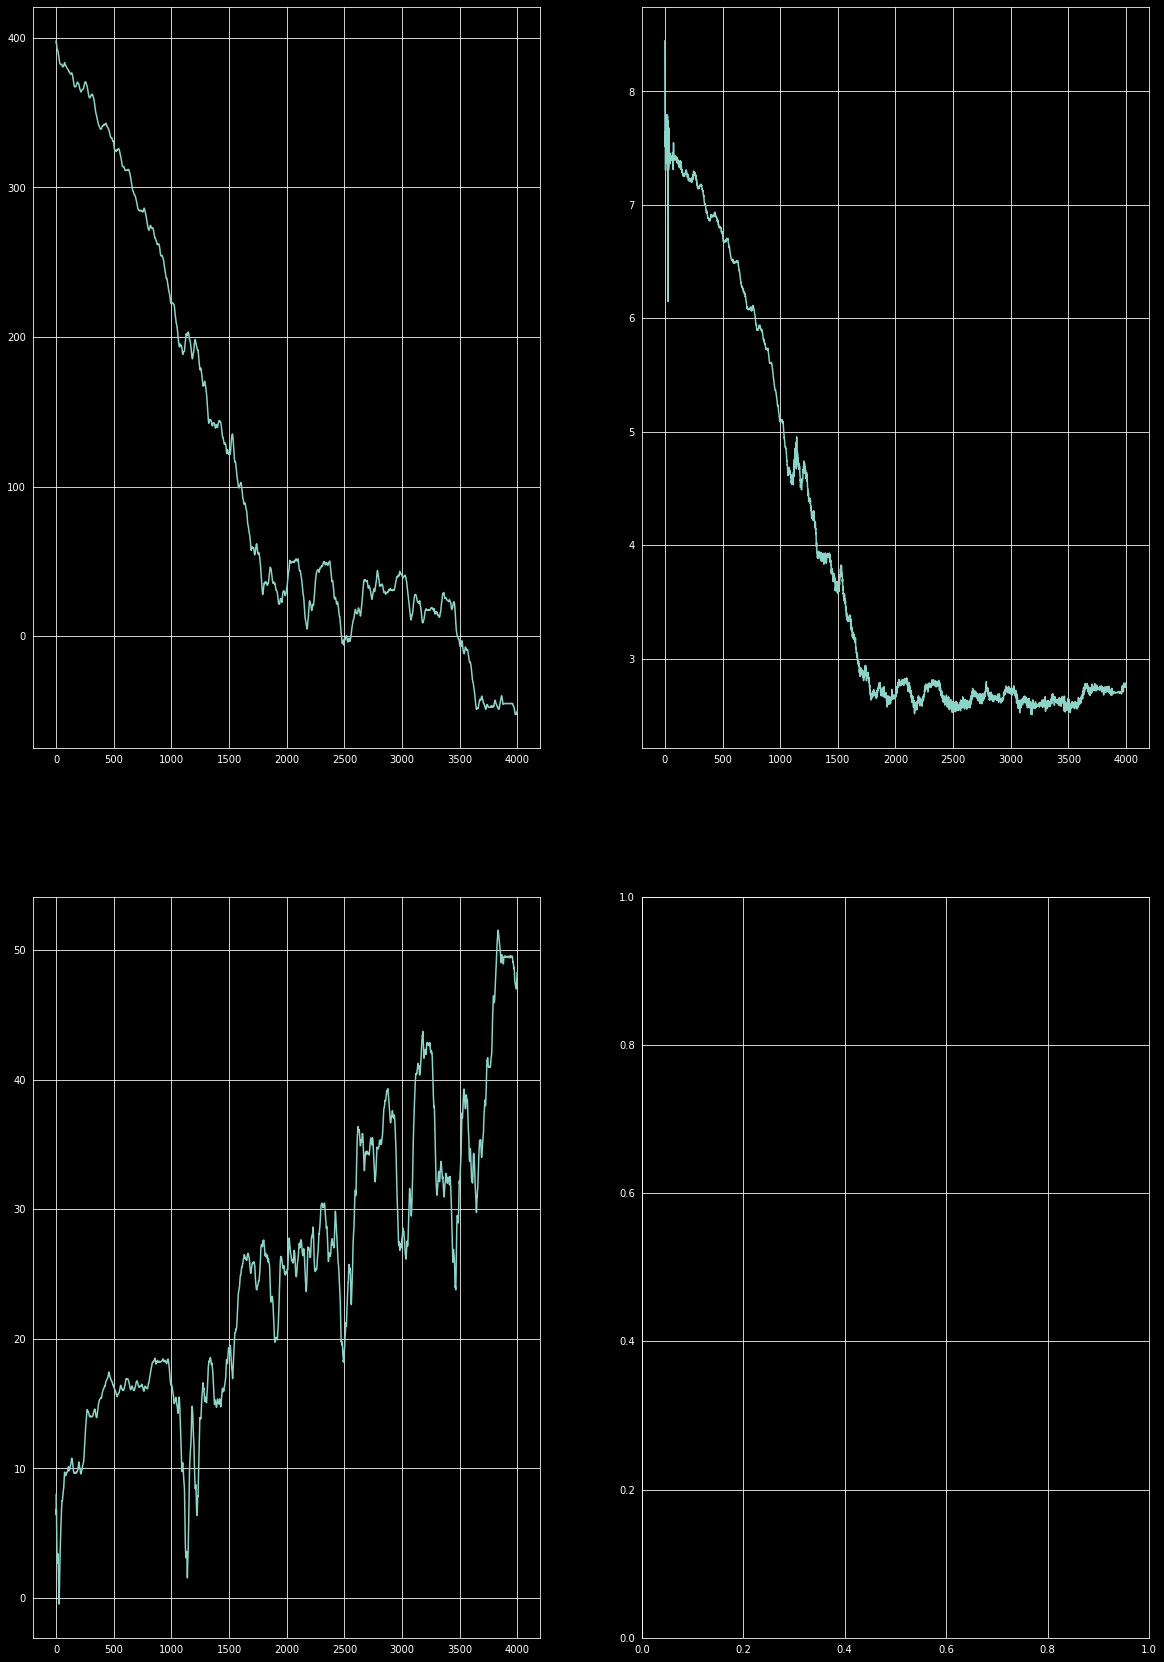

In [18]:
plt.style.use('dark_background')

fig, axes = plt.subplots(2, 2, figsize=(20, 30))
axes[0][0].plot([target_freq - x[-2] for x in train_res])

axes[0][1].plot([x[-1] for x in train_res])

axes[1][0].plot([x[1] for x in train_res])
plt.show()

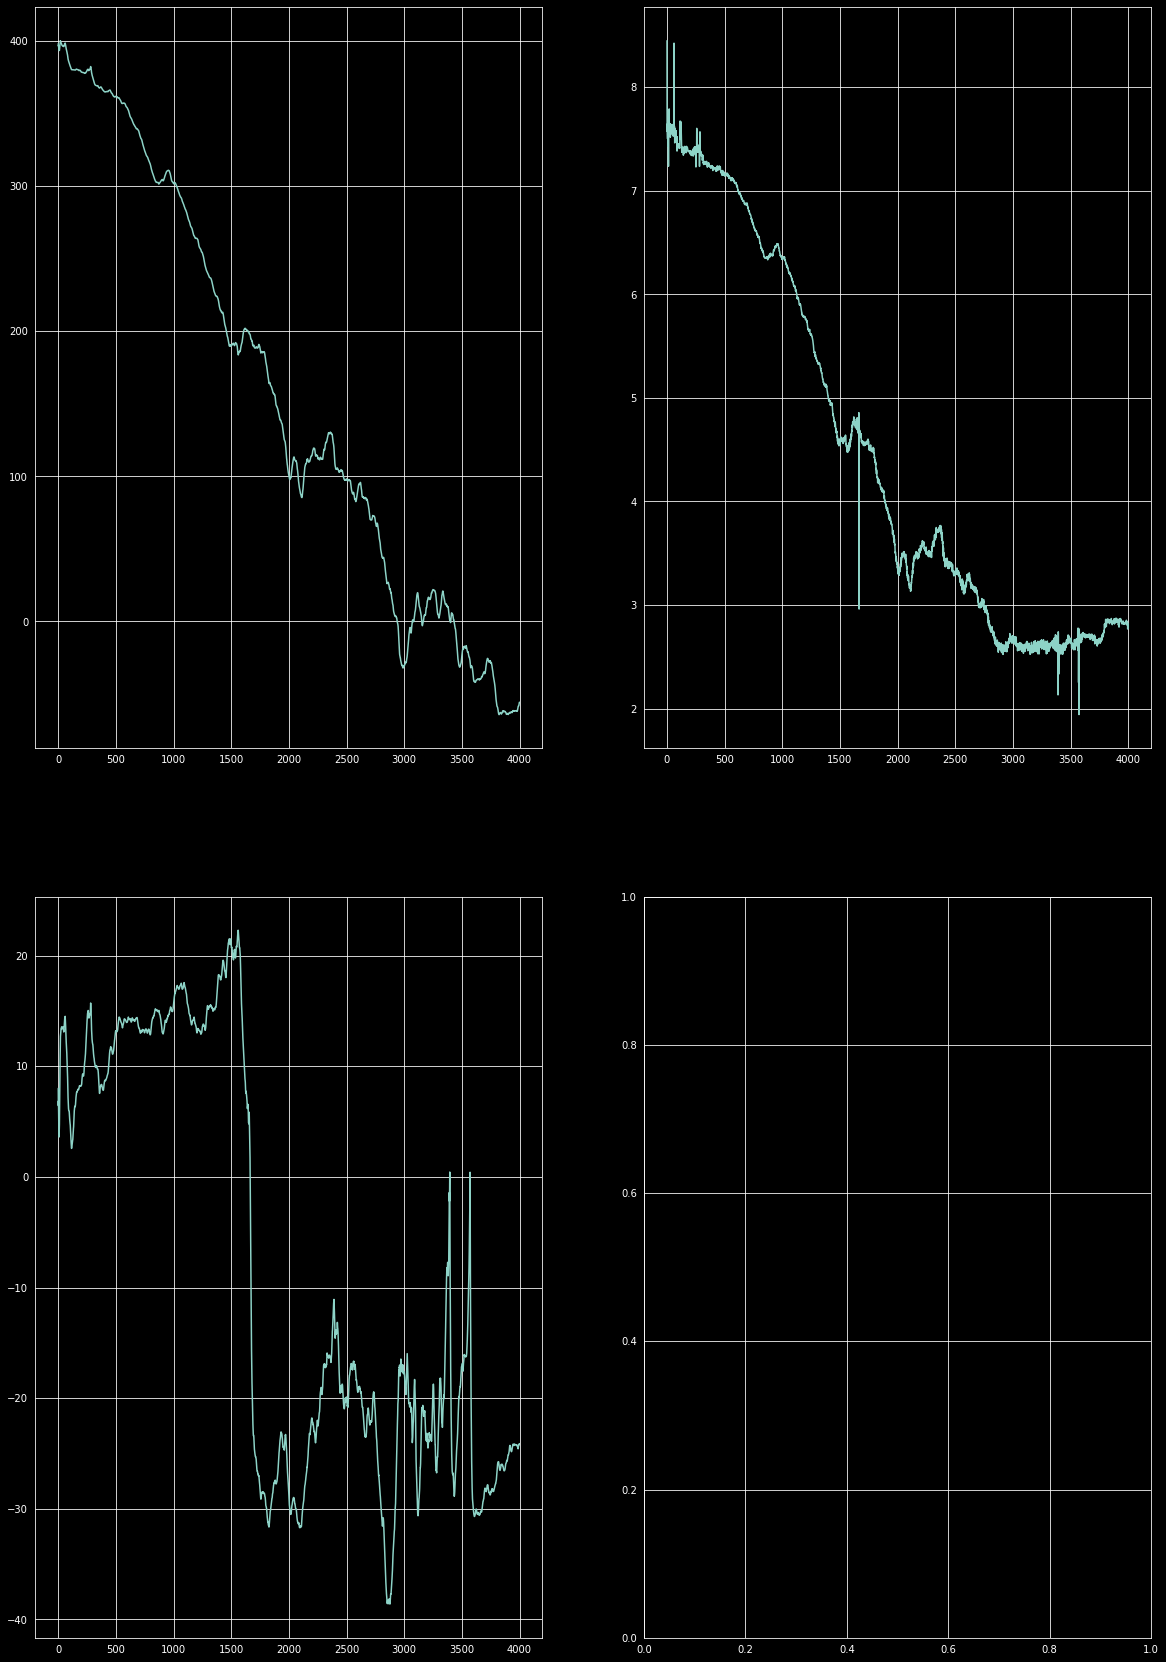

In [10]:
plt.style.use('dark_background')

fig, axes = plt.subplots(2, 2, figsize=(20, 30))
axes[0][0].plot([target_freq - x[-2] for x in train_res])

axes[0][1].plot([x[-1] for x in train_res])

axes[1][0].plot([x[1] for x in train_res])
plt.show()

In [ ]:
plt.plot([x[2] for x in train_res])
plt.show()

In [ ]:
from matplotlib import animation

fig, ax = plt.subplots(figsize=(15, 5))
l1, = ax.plot(param_range, loss_vals, 'o-', label='loss surface', markevery=[-1])
l2, = ax.plot([], [], 'o-', label='training progress')
ax.legend(loc='center right')
# ax.set_xlim(0,100)
# ax.set_ylim(0,1)

def animate(i):
    xi = [train_res[j][1] for j in range(i)]
    yi = [train_res[j][2] for j in range(i)]
    l2.set_data(xi, yi)
    return (l2)

animation.FuncAnimation(fig, animate, frames=num_epochs, interval=50)